# Process Noise Models (8-17)

In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
  %reload_ext autoreload
except:
  %load_ext autoreload
%autoreload 2

import sympy
from sympy import init_printing, lambdify, Matrix, MatMul, integrate, symbols, simplify, exp, zeros, factorial
import numpy as np

from math import sqrt
from scipy.linalg import expm, solve_discrete_lyapunov, sqrtm
from numpy.random import randn

init_printing(use_latex='mathjax')
dt, sWc, swd = symbols('T_s W_c \sigma^2_w')

Ts = 1 # time period 
sigma_squared_d = 0.5
sigma_squared_c = sigma_squared_d * Ts # rough scaling to make noise values approximately the same

Running Python: 3.8.16


## Continuous Time Process Noise Models Converted to Discrete

In [2]:
# Nx = 2 on 8-17: approx constant velocity
# Nx = 3 on 8-18: approx constant acceleration
#
def discretize_A_Wc(Nx=2):
    A = zeros(Nx,Nx)
    for kk in range(0,Nx-1):
        A[kk,kk+1] = 1
    B = zeros(Nx,1)
    B[Nx-1,0] = 1
    Ad = simplify(exp(A*dt))
    Wd=sympy.integrate(Ad * B * sWc * B.T * Ad.T, (dt, 0, dt))/sWc
    return Ad, sympy.MatMul(Wd, sWc)

# cts Nx = 2
Nx0 = 2
AA0,WW0 = discretize_A_Wc(Nx0)
fA0 = lambdify(dt, AA0)
fW0 = lambdify([dt, sWc], WW0)

Ad0 = fA0(Ts)
Wd0 = fW0(Ts,sigma_squared_c)
sWd0 = np.real(sqrtm(Wd0))

# cts Nx = 3
AA0_3,WW0_3 = discretize_A_Wc(3)
fA0_3 = lambdify(dt, AA0_3)
fW0_3 = lambdify([dt, sWc], WW0_3)

Ad0_3 = fA0_3(Ts)
Wd0_3 = fW0_3(Ts,sigma_squared_c)
sWd0_3 = np.real(sqrtm(Wd0_3))

## Discrete Process Noise Models

In [3]:
# 8-19: Nx = 2 with piecewise constant acceleration process noise
def DiscreteNoises(Nx = 2):
    Ad = zeros(Nx,Nx)
    Bd = zeros(Nx,1)
    for kk in range(0,Nx):
        Bd[kk,0] = (dt**(Nx-kk))/(factorial(Nx-kk))
        for jj in range(kk,Nx):
            Ad[kk,jj] = (dt**(jj-kk))/(factorial(jj-kk))
    Wd = sympy.MatMul(Bd@Bd.T,swd)
    return Ad,Wd,Bd 

Nx1 = 2
AA1,WW1,_ = DiscreteNoises(Nx1)
fA1 = lambdify(dt, AA1)
fW1 = lambdify([dt, swd], WW1)

Ad1 = fA1(Ts)
Wd1 = fW1(Ts,sigma_squared_d)
sWd1 = np.real(sqrtm(Wd1))

In [4]:
# 8-20: Nx = 3 with piecewise constant acceleration process noise
def DiscreteNoises2(Nx = 3):
    Ad = zeros(Nx,Nx)
    Bd = zeros(Nx,1)
    for kk in range(0,Nx):
        Bd[kk,0] = (dt**(Nx-kk-1))/(factorial(Nx-kk-1))
        for jj in range(kk,Nx):
            Ad[kk,jj] = (dt**(jj-kk))/(factorial(jj-kk))
    Wd = sympy.MatMul(Bd*Bd.T,swd)
    return Ad,Wd,Bd 

AA2,WW2,BB2 = DiscreteNoises2(3)
#AA2,WW2,BB2 = DiscreteNoises(3)
fA2 = lambdify(dt, AA2)
fW2 = lambdify([dt, swd], WW2)

Ad2 = fA2(Ts)
Wd2 = fW2(Ts,sigma_squared_d)
sWd2 = np.real(sqrtm(Wd2))

In [5]:
Npts = 1000
X0 = np.zeros((Nx0,1,Npts))
X0_3 = np.zeros((3,1,Npts))
X1 = np.zeros((2,1,Npts))
X2 = np.zeros((3,1,Npts))

np.random.seed(2000)
for k in np.arange(1,Npts,1):
    w_noise = np.vstack(randn(3))
    X0[:,:,k] = Ad0@X0[:,:,k-1] + sWd0@w_noise[0:Nx0]
    X0_3[:,:,k] = Ad0_3@X0_3[:,:,k-1] + sWd0_3@w_noise
    X1[:,:,k] = Ad1@X1[:,:,k-1] + sWd1@w_noise[0:Nx1]
    X2[:,:,k] = Ad2@X2[:,:,k-1] + sWd2@w_noise

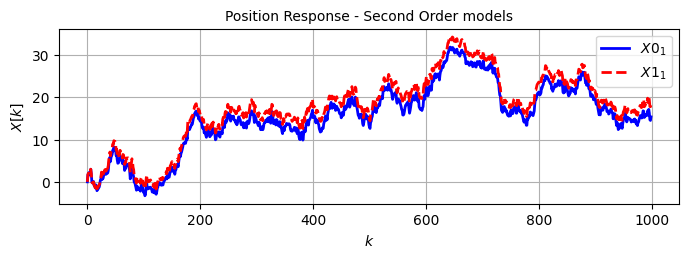

In [8]:
K=np.arange(0,Npts,1)
plt.figure(3,figsize=(8,5))
ax1 = plt.subplot(211)
ax1.plot(K,X0[1,0,:],'b-',label=r'$X0_{1}$')
ax1.plot(K,X1[1,0,:],'r--',label=r'$X1_{1}$')
#ax1.plot(K,X2[1,0,:],'g--',label=r'$X2_{1}$')
plt.ylabel(r'$X[k]$')
plt.xlabel(r'$k$')
#plt.xlim([0,N])
#plt.ylim([-50,50])
plt.grid(True)
plt.title('Position Response - Second Order models')
plt.legend(loc='best')
plt.tight_layout
plt.show()

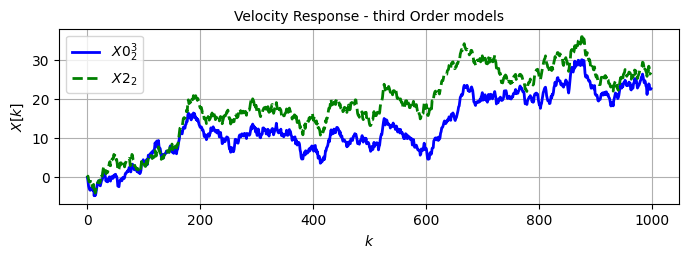

In [9]:
plt.figure(3,figsize=(8,5))
ax1 = plt.subplot(211)
#ax1.plot(K,X0[1,0,:],'b-',label=r'$X0_{1}$')
#ax1.plot(K,X1[1,0,:],'r--',label=r'$X1_{1}$')
ax1.plot(K,X0_3[2,0,:],'b-',label=r'$X0^3_{2}$')
ax1.plot(K,X2[2,0,:],'g--',label=r'$X2_{2}$')
plt.ylabel(r'$X[k]$')
plt.xlabel(r'$k$')
#plt.xlim([0,N])
#plt.ylim([-50,50])
plt.grid(True)
plt.title('Velocity Response - third Order models')
plt.legend(loc='best')
plt.tight_layout
plt.show()